# Modeling
## Predicting Rates of Chronic Absenteeism

### Imports 

In [19]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier 
import datetime
from pandas_profiling import ProfileReport

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.style as style
style.use('fivethirtyeight')

In [20]:
#load processed data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed'
os.chdir(path)

In [21]:
#create dummy variables for the two data frames
df_regressor = pd.read_csv('attendance_2013_18_regressor.csv', dtype={'District_Number': object})

#remove target variable from classification data, so it does not get turned into a dummy variable
df_classifier = pd.read_csv('attendance_2013_18_classifier.csv', dtype={'District_Number': object})

In [22]:
#check to ensure District Number is correctly an object, not int
df_regressor.dtypes

Grade                              object
Year                               object
Demographic Variable               object
% Attendance                      float64
% Chronically Absent              float64
Next Year % Chronically Absent    float64
District_Number                    object
dtype: object

This time we will try the models by dropping `% Chronically Absent`, as this will make the models more usable/generalizable in a larger context.

In [23]:
#create dummy variables for the two data frames
df_regressor_dummies = pd.get_dummies(df_regressor.drop(columns=['% Chronically Absent']))

#remove target variable from classification data, so it does not get turned into a dummy variable
df_classifier_dummies = pd.get_dummies(df_classifier.drop(columns=['Chronically_Absent_Next_Year', '% Chronically Absent']))

#save target variable for classification
target_classifier = df_classifier['Chronically_Absent_Next_Year']

print(df_classifier_dummies.shape)
print(df_regressor_dummies.shape)

(453956, 68)
(453956, 69)


In [24]:
#define variables for regressor
X = df_regressor_dummies.drop(columns=['Next Year % Chronically Absent'])
y = df_regressor_dummies['Next Year % Chronically Absent']

In [25]:
#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Modeling

### Initial Benchmark - Dummy Regressor

In [96]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

27.31792586248235

In [97]:
#Fit the dummy regressor on the training data
#Then print the object's `constant_` attribute and verify it's the same as the mean above
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[27.31792586]])

In [98]:
#create dummy regressor predictions 
y_tr_pred = dumb_reg.predict(X_train)
#Make prediction with the single value of the (training) mean.
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0003902419452113115)

In [99]:
#establish baseline for mean absolute error and mean square error 
print('MAEs:', mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred))
print('MSEs:', mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred))

MAEs: 14.425187661095018 14.407710596424323
MSEs: 313.6617613921039 312.10496683625587


### Linear Regression Model

In [100]:
lm = LinearRegression().fit(X_train, y_train)

In [101]:
#Make predictions using the model on both train and test splits
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [102]:
#Assess model performance
# r^2 - train, test
r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
print('r2:', r2)

r2: (0.6639015851045162, 0.6323296570962034)


In [103]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
print('mae:', mae)

mae: (7.6280049057708075, 8.001446269821166)


In [104]:
# MSE - train, test
mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
print('mse:', mse)

mse: (105.42122081721159, 114.70697670494565)


In [105]:
#try cross validation, results may be innacurate due to time series split..
cv_results = cross_validate(LinearRegression(), X_train, y_train, cv=5)

In [54]:
cv_scores = cv_results['test_score']
cv_scores

array([ 7.19282969e-01,  7.02694889e-01,  6.98377976e-01,  6.94595518e-01,
       -2.42399082e+18])

In [55]:
np.mean(cv_scores), np.std(cv_scores)

(-4.847981633603145e+17, 9.69596326720629e+17)

In [56]:
#hyperparameter tuning

In [57]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

## Initial Classification Models

In [26]:
#define variables for classifier
X_c = df_classifier_dummies
y_c = target_classifier

In [27]:
# dividing X_c, y_c into train and test data 
#X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, random_state = 0) 

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X_c):
    X_train, X_test = X_c.iloc[train_index, :], X_c.iloc[test_index,:]
    y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]

### Descion Tree

In [28]:
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [29]:
print(dtree_model.score(X_test, y_test))
print(cm)
print(classification_report(y_test, dtree_predictions))

0.7609669702216524
[[ 9009    29  4131]
 [   59  7650  4442]
 [ 5738  3686 40915]]
              precision    recall  f1-score   support

        High       0.61      0.68      0.64     13169
         Low       0.67      0.63      0.65     12151
      Medium       0.83      0.81      0.82     50339

    accuracy                           0.76     75659
   macro avg       0.70      0.71      0.70     75659
weighted avg       0.76      0.76      0.76     75659



### K-Nearest Neighbors

In [30]:
# Create a k-NN classifier
knn = KNeighborsClassifier()

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
# Predict the labels for the training data X
y_pred = knn.predict(X_test)

In [32]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7737612180969878


In [33]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 7820    38  5311]
 [   58  7175  4918]
 [ 3575  3217 43547]]
              precision    recall  f1-score   support

        High       0.68      0.59      0.64     13169
         Low       0.69      0.59      0.64     12151
      Medium       0.81      0.87      0.84     50339

    accuracy                           0.77     75659
   macro avg       0.73      0.68      0.70     75659
weighted avg       0.77      0.77      0.77     75659



### To do...
- Look at modeling springboard docs
- do other models (**deep learning**, naive bayes, svm)
- tune descion tree
- visualize decision tree (look at my springboard decision tree project).. 
- look at springboard projects for classfication
- do a few regression models (random forest)
- **tune hyperparamters**
- Feature importance
- predict next years on 2018-2019 data (look at and compare with today's data)

## Hyperparamter Tuning

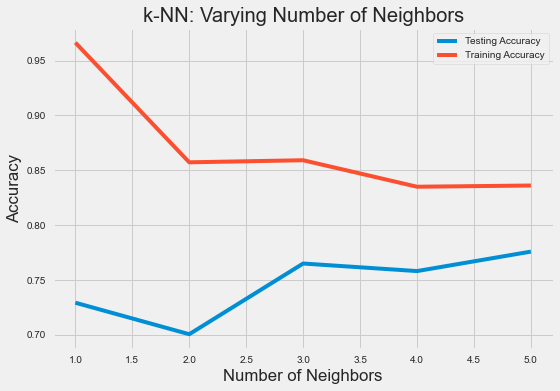

In [67]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 6)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Try running this for neighbors = range(6-10). This was done because running time for full range took too long.

In [ ]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 6)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Regenerate model for K=...

In [ ]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=6)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Tuning Decision Tree Classifier

In [ ]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

In [ ]:
# Predict the labels of the test set: y_pred
y_pred = tree_cv.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## Took a long time...

In [ ]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 

In [ ]:
cm
#also print classification report

In [ ]:
# training a linear SVM classifier 
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

In [ ]:
print('accuracy:', accuracy)
print(cm)
##also print classification report

### Tensorflow Deep Learning Model

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
import warnings
#warnings.filterwarnings(“ignore”)

2.3.1


In [8]:
#Reset TF session parameters
#tf.keras.backend.clear_session()

In [9]:
#define variables for tensorflow regressor
X = df_regressor.drop(columns=['Next Year % Chronically Absent'])
y = df_regressor['Next Year % Chronically Absent']

#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [7]:
df_regressor.head()

,Grade,Year,Demographic Variable,% Attendance,% Chronically Absent,Next Year % Chronically Absent,District_Number
0,All Grades,2013-14,All Students,92.0,26.9,23.4,01
1,PK in K-12 Schools,2013-14,All Students,88.1,53.3,65.2,01
2,0K,2013-14,All Students,90.7,29.5,30.0,01
3,1,2013-14,All Students,92.2,31.0,18.8,01
4,2,2013-14,All Students,92.3,20.0,21.9,01


In [15]:
# Define feature columns from df_classifier columns
grade = tf.feature_column.categorical_column_with_vocabulary_list("grade", ['All Grades', 'PK in K-12 Schools', '0K', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
year = tf.feature_column.categorical_column_with_vocabulary_list("year", ['2013-14', '2014-15', '2015-16', '2016-17', '2017-18'])
demographic = tf.feature_column.categorical_column_with_vocabulary_list("demographic", ['All Students', 'Not SWD', 'SWD', 'Asian', 'Black', 'Hispanic', 'Other', 'White', 'Female', 'Male', 'Not Poverty', 'Poverty', 'ELL', 'Not ELL'])
district = tf.feature_column.categorical_column_with_vocabulary_list("district", ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '75'])
attendance = tf.feature_column.numeric_column("attendance")

# Define the list of feature columns
feature_list = [grade, year, demographic, district, attendance]

def input_fn():
    # Define the labels
    labels = np.array(y_train)
    # Define the features
    features = {'grade':np.array(X_train.Grade), 
                'year':np.array(X_train.Year),
                'demographic':np.array(X_train['Demographic Variable']), 
                'district':np.array(X_train['District_Number']),
                'attendance':np.array(X_train['% Attendance']),}
    return features, labels

In [17]:
model2 = tf.estimator.DNNRegressor(feature_columns=feature_list, hidden_units=[4,3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/7t/tf7qqbkd5sg4pclppz41qf3w0000gn/T/tmprvo9a87i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [18]:
model1.train(input_fn, steps=1)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


ValueError: Items of feature_columns must be a <class 'tensorflow.python.feature_column.feature_column_v2.DenseColumn'>. You can wrap a categorical column with an embedding_column or indicator_column. Given: VocabularyListCategoricalColumn(key='demographic', vocabulary_list=('All Students', 'Not SWD', 'SWD', 'Asian', 'Black', 'Hispanic', 'Other', 'White', 'Female', 'Male', 'Not Poverty', 'Poverty', 'ELL', 'Not ELL'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [73]:
#Configure the model
model = tf.keras.models.Sequential([tf.keras.layers.Dense(36, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(18, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(9, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)])

#delete flaatten, change layers to match my problem 36, 18, 9 --> 3

In [74]:
#Compile the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [75]:
#fit the model
model.fit(training_images_data, training_labels, epochs=10)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



UnimplementedError:  Cast string to float is not supported
	 [[node sparse_categorical_crossentropy/Cast (defined at <ipython-input-75-70f414ef807c>:2) ]] [Op:__inference_train_function_742]

Function call stack:
train_function


In [ ]:
#test model performance
model.evaluate(test_images_data, test_labels)

### Saved Best Model

## Notes /Summary

In [ ]:
#remember because of time series split is a form of cross validation...

In [ ]:
#a classification model, you should implement both an entropy model and a Gini impurity model. 


In [68]:
#need to do feature importance before dropping `% Chronically Absent!!`

- Fit your models with a training dataset
- Review model outcomes — Iterate over additional models as needed
- Identify the final model that you think is the best model for this project
    - Not always the most accurate (think about what I want my model to best predict ('high' chronic absentee schools)
        - too many False positives = ok for schools with larger budgets, want to ensure they got all the schools
        - too many False negatives = ok for schools with smaller budgets? want to ensure a school they focus on will really need it

We will try to turn chronic absenteeism from a multi class categorical variable to a binary variable.. As we are concerned mostly with whether Chronic Absenteeism is 'High' or not.

In [ ]:
#Turn chronic absenteeism from multi class to binary
1 = High
0 = Low
    
# defining function to check price 
def fun(num): 
  
    if num< (mean - std): 
        return "Low"
  
    elif num>= (mean - std) and num <= (mean + std): 
        return "Medium"
    
    elif num > (mean+ std):
        return "High"
  
    else: 
        return np.nan